# Transformers - Speech commands classification with Transformers

## Code/Data-Preparation

In [29]:
# Install dependencies
! pip install numpy
! pip install matplotlib
! pip install seaborn
! pip install scikit-learn
! pip install scipy

! pip install tensorflow --upgrade
! pip install keras --upgrade

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/11.6 MB 1.1 MB/s eta 0:00:11
    --------------------------------------- 0.3/11.6 MB 2.3 MB/s eta 0:00:06
   -- ------------------------------------- 0.7/11.6 MB 4.5 MB/s eta 0:00:03
   ---- ----------------------------------- 1.4/11.6 MB 7.1 MB/s eta 0:00:02
   -------- ------------------------------- 2.5/11.6 MB 10.0 MB/s eta 0:00:01
   ------------- -------------------------- 3.9/11.6 MB 12.9 MB/s eta 0:00:01
   ------------------ --------------------- 5.4/11.6 MB 15.5 MB/s eta 0:00:01
   ---------------------- ----------------- 6.7/11.6 MB 17.0 MB/s 

In [5]:
# Please read the guidelines on https://www.kaggle.com/docs/api#authentication
# to get an idea where to put your kaggle API token to be able to download the dataset

! pip install kaggle
! kaggle competitions download -c "tensorflow-speech-recognition-challenge"

! tar -xf tensorflow-speech-recognition-challenge.zip -C ../data/challenge
! del tensorflow-speech-recognition-challenge.zip

# To extract the dataset, we need to have 7-zip (https://www.7-zip.org/) installed and added to our $PATH
! 7z x -o..\data\challenge ..\data\challenge\test.7z
! 7z x -o..\data\challenge ..\data\challenge\train.7z



  0%|          | 0.00/3.50G [00:00<?, ?B/s]
  0%|          | 1.00M/3.50G [00:00<39:21, 1.59MB/s]
  0%|          | 2.00M/3.50G [00:00<20:06, 3.12MB/s]
  0%|          | 4.00M/3.50G [00:00<09:25, 6.65MB/s]
  0%|          | 6.00M/3.50G [00:00<06:31, 9.60MB/s]
  0%|          | 8.00M/3.50G [00:01<05:35, 11.2MB/s]
  0%|          | 10.0M/3.50G [00:01<05:00, 12.5MB/s]
  0%|          | 12.0M/3.50G [00:01<04:38, 13.5MB/s]
  0%|          | 14.0M/3.50G [00:01<04:25, 14.1MB/s]
  0%|          | 16.0M/3.50G [00:01<04:18, 14.5MB/s]
  1%|          | 18.0M/3.50G [00:01<04:00, 15.5MB/s]
  1%|          | 21.0M/3.50G [00:01<03:35, 17.3MB/s]
  1%|          | 23.0M/3.50G [00:02<03:30, 17.7MB/s]
  1%|          | 25.0M/3.50G [00:02<03:28, 17.9MB/s]
  1%|          | 27.0M/3.50G [00:02<03:28, 17.9MB/s]
  1%|          | 29.0M/3.50G [00:02<03:30, 17.8MB/s]
  1%|          | 31.0M/3.50G [00:02<03:35, 17.3MB/s]
  1%|          | 34.0M/3.50G [00:02<03:13, 19.3MB/s]
  1%|          | 36.0M/3.50G [00:02<03:22, 18.4MB/s]
 


7-Zip 23.01 (x64) : Copyright (c) 1999-2023 Igor Pavlov : 2023-06-20

Scanning the drive for archives:
1 file, 2640679130 bytes (2519 MiB)

Extracting archive: ..\data\challenge\test.7z
--
Path = ..\data\challenge\test.7z
Type = 7z
Physical Size = 2640679130
Headers Size = 1345163
Method = Delta LZMA2:24
Solid = +
Blocks = 3

Everything is Ok

Folders: 2
Files: 158538
Size:       5080191672
Compressed: 2640679130

7-Zip 23.01 (x64) : Copyright (c) 1999-2023 Igor Pavlov : 2023-06-20

Scanning the drive for archives:
1 file, 1121103842 bytes (1070 MiB)

Extracting archive: ..\data\challenge\train.7z
--
Path = ..\data\challenge\train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

Everything is Ok

Folders: 33
Files: 64732
Size:       2055161498
Compressed: 1121103842


In [30]:
# Imports
from pathlib import Path
from scipy.io import wavfile
from scipy import signal

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Loading

In [15]:
train_path = Path(Path('.').resolve().parent, "data/challenge/train/audio/")

### Visualisation
To check if data is of the expected format, we visualise characteristics some example file. The code for this part is adapted from https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration

In [23]:
# Define and open file to visualise
file_to_visualise = "yes/0a7c2a8d_nohash_0.wav"
filepath = Path(train_path, file_to_visualise)
sample_rate, data = wavfile.read(filepath)

Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear. We need to assure that there are no 0 values as input to logarithm.


(From https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=5)


In [28]:
# Define a function that calculates spectrogram. (https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=6)
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

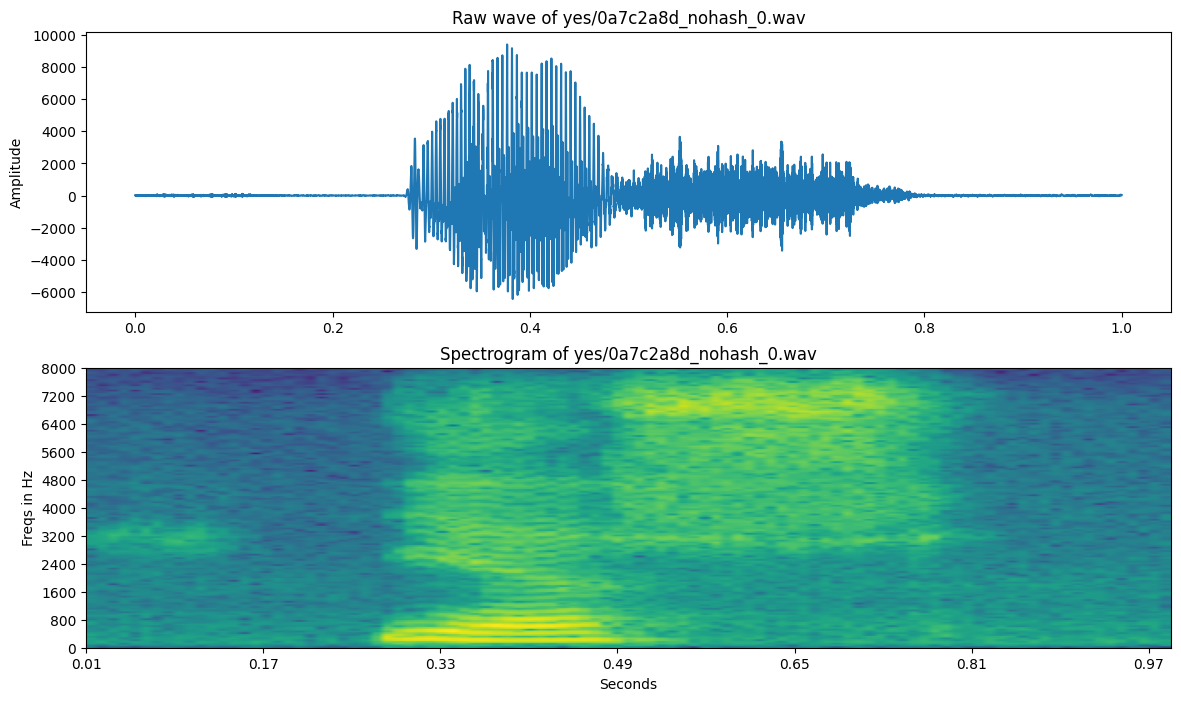

In [32]:
freqs, times, spectrogram = log_specgram(data, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + file_to_visualise)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(data), sample_rate), data)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + file_to_visualise)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

## CNN
We train a CNN to classify the speech data